## Elevation Exploration

This is a notebook to checkout the elevation grid used by NCAR to generate the dataset. We received this grid from Andrew Newman at NCAR with the following information: 

```
"I've attached the grid we used with elevation (across a wider region) and the grid mask. Elevation isn't strictly an input to BCSD, and the underlying Daymet 'observed' precipitation data were generated on a 1 km grid, so moving to our 12km grid and the corresponding elevation we have is somewhat of a mismatch. That being said, because Daymet accounts for elevation in some fashion, the final 12km BCSD product will also account for elevation because of the training to the Daymet observations and application of that bias adjustment and spatial disaggregation to the GCM data."
```

In this notebook we'll just examine the grid and the mask, and then write the elevation data to an EPSG:3338 GeoTIFF in the same way that we handled the other datasets.

In [1]:
from pathlib import Path

import xarray as xr
import rasterio as rio
import numpy as np
from pyproj import Proj, Transformer, CRS
from wrf import PolarStereographic
from rasterio.warp import calculate_default_transform, reproject, Affine, Resampling, aligned_target
from rasterio.transform import array_bounds
from rasterio.windows import Window

# local
from compute_summaries import write_raster_to_disk
from config import aux_dir

In [2]:
dem = xr.open_dataset("alaska_grid_12km_production.nc")
dem

<xarray.Dataset>
Dimensions:  (y: 209, x: 299)
Dimensions without coordinates: y, x
Data variables:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
    mask     (y, x) float32 ...
    HGT_M    (y, x) float32 ...
Attributes:
    history:                    Fri Jun 15 17:49:47 2018: ncks -A -v HGT_M te...
    history_of_appended_files:  Fri Jun 15 17:49:47 2018: Appended file temp....
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...
    nco_openmp_thread_number:   1

In [3]:
dem.HGT_M

<xarray.DataArray 'HGT_M' (y: 209, x: 299)>
[62491 values with dtype=float32]
Dimensions without coordinates: y, x
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    units:         meters MSL
    description:   GMTED2010 30-arc-second topography height
    stagger:       M
    sr_x:          1
    sr_y:          1
    cell_methods:  Time: mean

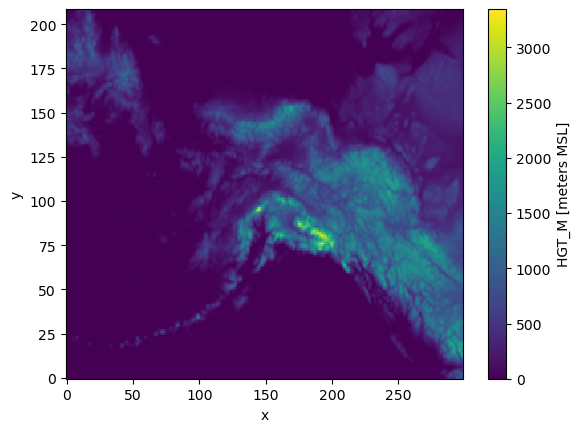

In [4]:
dem.HGT_M.plot()

In [5]:
dem.mask

<xarray.DataArray 'mask' (y: 209, x: 299)>
[62491 values with dtype=float32]
Dimensions without coordinates: y, x
Attributes:
    cell_methods:  area: mean time: sum time: mean
    grid_mapping:  lambert_conformal_conic
    long_name:     daily total precipitation
    remap:         remapped via ESMF_regrid_with_weights: Bilinear
    units:         mm/day

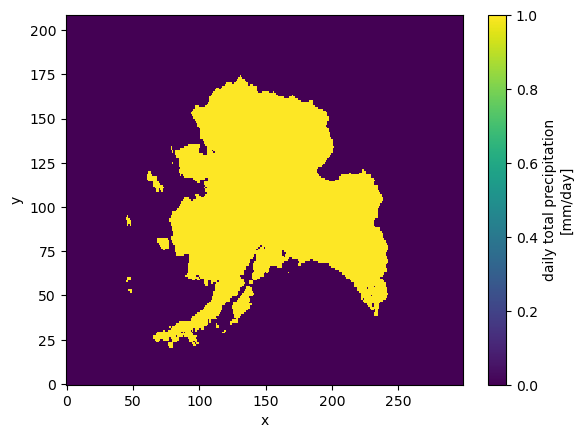

In [6]:
dem.mask.plot()

In [7]:
wrf_proj_str = PolarStereographic(**{"TRUELAT1": 64, "STAND_LON": -150}).proj4()
wrf_proj = Proj(wrf_proj_str)
wgs_proj = Proj(proj='latlong', datum='WGS84')

transformer = Transformer.from_proj(wgs_proj, wrf_proj)
e, n = transformer.transform(-150, 64)
# Grid parameters
dx, dy = 12000, 12000

try:
    ny, nx = dem.lon.shape[1:]
except:
    ny, nx = dem.lon.shape # met case has a little different structure

# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n
# 2d grid
x = np.arange(nx) * dx + x0
y = np.arange(ny) * dy + y0

projected_datacube = dem.assign_coords({"y": ("y", y), "x": ("x", x)})

# Output geotiff creation profile params  
width = dem.x.shape[0]
height = dem.y.shape[0]

# west and north
west = x0 - dx / 2
north = y[-1] + dy / 2
out_transform = rio.transform.from_origin(west, north, dx, dy)

wrf_raster_profile = {
    "driver": "GTiff",
    "crs": CRS.from_proj4(wrf_proj_str),
    "transform": out_transform,
    "width": width,
    "height": height,
    "count": 1,
    "dtype": np.float32,
    "nodata": -9999,
    "tiled": False,
    "compress": "lzw",
    "interleave": "band",
}

In [8]:
projected_datacube

<xarray.Dataset>
Dimensions:  (y: 209, x: 299)
Coordinates:
  * y        (y) float64 -4.04e+06 -4.028e+06 ... -1.556e+06 -1.544e+06
  * x        (x) float64 -1.788e+06 -1.776e+06 ... 1.776e+06 1.788e+06
Data variables:
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
    mask     (y, x) float32 ...
    HGT_M    (y, x) float32 ...
Attributes:
    history:                    Fri Jun 15 17:49:47 2018: ncks -A -v HGT_M te...
    history_of_appended_files:  Fri Jun 15 17:49:47 2018: Appended file temp....
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...
    nco_openmp_thread_number:   1

In [9]:
dem_data = np.flipud(projected_datacube.HGT_M.data)
dem_data

array([[3.1056293e+01, 1.5500687e+01, 1.4387003e+01, ..., 0.0000000e+00,
        0.0000000e+00, 1.2228811e-01],
       [4.4530945e+01, 2.2303303e+01, 2.9358955e+01, ..., 0.0000000e+00,
        0.0000000e+00, 1.1343594e+00],
       [5.8605026e+01, 2.8464798e+01, 3.2639458e+01, ..., 8.2251079e-02,
        3.9823011e-02, 3.9268651e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.6971704e+02,
        9.1086023e+02, 8.9914795e+02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.4944763e+02,
        7.9341211e+02, 8.4668323e+02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.5177820e+02,
        6.9156812e+02, 6.6882153e+02]], dtype=float32)

In [10]:
dem_data.shape

(209, 299)

In [11]:
dem_data.min()

0.0

In [12]:
dem_data.max()

3347.0078

In [13]:
help(write_raster_to_disk)

Help on function write_raster_to_disk in module compute_summaries:

write_raster_to_disk(out_filename, raster_profile, raster_data)
    Args:
        out_filename (str): name of the output GeoTIFF.
        raster_profile (dict): raster profile parameters used to create the output GeoTIFF.
        raster_data (ndarray): raster data to be written to disk.
    
    Returns:
        None



In [14]:
with rio.open("ncar_elevation_grid.tif", "w", **wrf_raster_profile) as dst:
    dst.write(dem_data, 1)

In [15]:
dst_crs = rio.crs.CRS.from_epsg(3338)
tr = 12000
# we know we want these output dimensions based on the results from `gdalwarp -tap -tr 12000 12000`
t_width = 317
t_height = 224

In [18]:
# grabbing the function from the reproject notebook
def reproject_raster(file, target_directory, name_prefix):
    with rio.open(file) as src:
        
        # compute the new affine transformation, width and height
        warp_transform, width, height = rio.warp.calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=(tr, tr))
        tap_transform, tap_width, tap_height = aligned_target(warp_transform, t_width - 1, t_height - 1, tr) # the -1 might just be an indexing thing
        # but without the offset, the output height and width are too large (by 1) when compared to what is created by gdalwarp -tap
    
        # define the output raster profile
        out_profile = src.profile.copy()
        out_profile.update({
            "crs": dst_crs,
            "transform": tap_transform,
            "width": t_width,
            "height": t_height,
            "bounds": array_bounds(tap_height, tap_width, tap_transform)
         })

        # create the new raster file
        out_file = target_directory / f"{name_prefix}{file}"
        with rio.open(out_file, 'w', **out_profile) as dst:
            # reproject the input raster data
            rio.warp.reproject(
                source=src.read(1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=tap_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest # this is the default, just being explicit here for easy change or experimentation later
            )

In [19]:
reproject_raster("ncar_elevation_grid.tif", aux_dir, "epsg3338_")